In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from src.visualization.plots import plot_score_differences
import warnings
warnings.filterwarnings('ignore')

In [3]:
df_score_differences = pd.read_parquet('data/results/score_differences_data.parquet')
df_performance_results = pd.read_parquet('data/results/performance_data.parquet')
df_description = pd.read_parquet('data/results/df_description_data.parquet')

In [4]:
mask = (df_score_differences['minority_class_complexity'] != df_score_differences['most_complex_class']) & (df_score_differences['k'] == 1)
df_score_differences_filtered = df_score_differences[mask]
display(df_score_differences_filtered)

,dataset,metric_x,score,score_sd,k,metric_y,minority_class_complexity,most_complex_class,diff_score_minority_class_complexity,diff_score_most_complex_class
88,banknote,accuracy_score,1.000000,0.000000e+00,1,kdn,0.000000,0.003937,0.000000e+00,0.003937
89,banknote,accuracy_score,1.000000,0.000000e+00,1,ddn,0.000000,0.003937,0.000000e+00,0.003937
550,splice,accuracy_score,0.966000,1.280625e-02,1,kdn,0.124224,0.471954,9.022360e-02,0.437954
551,splice,accuracy_score,0.966000,1.280625e-02,1,ddn,0.125259,0.470986,9.125880e-02,0.436986
1462,banknote,f1_score,1.000000,0.000000e+00,1,kdn,0.000000,0.003937,0.000000e+00,0.003937
1463,banknote,f1_score,1.000000,0.000000e+00,1,ddn,0.000000,0.003937,0.000000e+00,0.003937
1924,splice,f1_score,0.965165,1.330887e-02,1,kdn,0.124224,0.471954,8.938816e-02,0.437118
1925,splice,f1_score,0.965165,1.330887e-02,1,ddn,0.125259,0.470986,9.042336e-02,0.436151
2836,banknote,gps_score,1.000000,1.087792e-15,1,kdn,0.000000,0.003937,-2.573786e-11,0.003937
2837,banknote,gps_score,1.000000,1.087792e-15,1,ddn,0.000000,0.003937,-2.573786e-11,0.003937


In [5]:
suspicious_dfs = df_score_differences[mask].dataset.unique()
suspicious_dfs

array(['banknote', 'splice'], dtype=object)

In [6]:
def prepare_data(df_description, df_score_differences, df_performance_results, k):
    """
    Prepares the data by filtering, categorizing, and merging the required DataFrames.

    Parameters:
    -----------
    df_description : pd.DataFrame
        DataFrame containing dataset descriptions with class proportions.
    df_score_differences : pd.DataFrame
        DataFrame containing score differences for different values of k.
    df_performance_results : pd.DataFrame
        DataFrame containing best method information.
    k : int
        The specific value of k to filter the data.

    Returns:
    --------
    pd.DataFrame
        Merged DataFrame with filtered and categorized data.
    """
    # Define bins and labels for class_prop categories
    bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
    labels = ['0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5']
    
    # Create class_prop_category in df_description
    df_description['class_prop_category'] = pd.cut(df_description['class_prop'], bins=bins, labels=labels, include_lowest=True)
    
    # Reset index and rename it to 'dataset'
    df_description.reset_index(inplace=True)
    df_description.rename(columns={'index': 'dataset'}, inplace=True)

    # Filter data for the specified k value
    df_filtered = df_score_differences[df_score_differences['k'] == k]

    # Merge with best method information
    df_merged = df_filtered.merge(df_description[['dataset', 'class_prop_category']], on='dataset', how='inner')
    df_merged = df_merged.merge(
        df_performance_results[['dataset', 'best_method']].drop_duplicates(subset=['dataset']),
        on='dataset',
        how='inner'
    )
    
    return df_merged

def calculate_grouped_statistics(df, diff='diff_score_most_complex_class', x_var='best_method'):
    """
    Calculates grouped statistics for the 'diff' variable based on 'x_var' and 'metric_y'.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the data.
    diff : str, optional (default='diff_score_most_complex_class')
        Column name for the variable for which to calculate statistics.
    x_var : str, optional (default='best_method')
        Column name for the grouping variable along the x-axis.

    Returns:
    --------
    pd.DataFrame
        DataFrame containing the grouped statistics.
    """
    # Group by the specified variables and calculate statistics
    grouped_stats = df.groupby([x_var, 'metric_y'])[diff].agg(['median','mean', 'std', 'min', 'max', 'count']).reset_index()
    
    return grouped_stats

In [7]:
df_merged = prepare_data(df_description, df_score_differences, df_performance_results, 1)

In [8]:
df_merged

,dataset,metric_x,score,score_sd,k,metric_y,minority_class_complexity,most_complex_class,diff_score_minority_class_complexity,diff_score_most_complex_class,class_prop_category,best_method
0,a9a,accuracy_score,0.850035,0.003225,1,kdn,0.375717,0.375717,0.225753,0.225753,0.2-0.3,GradientBoostingClassifier
1,a9a,accuracy_score,0.850035,0.003225,1,ddn,0.423633,0.423633,0.273669,0.273669,0.2-0.3,GradientBoostingClassifier
2,appendicitis,accuracy_score,0.887013,0.056549,1,kdn,0.380952,0.380952,0.267965,0.267965,0.1-0.2,SVC
3,appendicitis,accuracy_score,0.887013,0.056549,1,ddn,0.380952,0.380952,0.267965,0.267965,0.1-0.2,SVC
4,australian,accuracy_score,0.875362,0.037345,1,kdn,0.234528,0.234528,0.109890,0.109890,0.4-0.5,GradientBoostingClassifier
...,...,...,...,...,...,...,...,...,...,...,...,...
515,glass1,scaled_mcc_score,0.809645,0.069831,1,ddn,0.289474,0.289474,0.099119,0.099119,0.3-0.4,GradientBoostingClassifier
516,newthyroid2,scaled_mcc_score,0.984466,0.019025,1,kdn,0.028571,0.028571,0.013038,0.013038,0.1-0.2,KNeighborsClassifier
517,newthyroid2,scaled_mcc_score,0.984466,0.019025,1,ddn,0.028571,0.028571,0.013038,0.013038,0.1-0.2,KNeighborsClassifier
518,vehicle2,scaled_mcc_score,0.987671,0.007849,1,kdn,0.036697,0.036697,0.024368,0.024368,0.2-0.3,GradientBoostingClassifier


In [9]:
calculate_grouped_statistics(df_merged, diff='diff_score_most_complex_class', x_var='best_method')

,best_method,metric_y,median,mean,std,min,max,count
0,GradientBoostingClassifier,ddn,0.101052,0.132754,0.159208,-0.144416,0.581721,68
1,GradientBoostingClassifier,kdn,0.097711,0.118973,0.155140,-0.145937,0.581721,68
2,KNeighborsClassifier,ddn,0.126750,0.135271,0.113886,-0.000147,0.468197,28
3,KNeighborsClassifier,kdn,0.126750,0.135271,0.113886,-0.000147,0.468197,28
4,RandomForestClassifier,ddn,0.210425,0.225971,0.144962,0.058444,0.677778,40
5,RandomForestClassifier,kdn,0.215696,0.237047,0.163997,0.038453,0.677778,40
6,SVC,ddn,0.072229,0.091276,0.166032,-0.388638,0.441694,124
7,SVC,kdn,0.071190,0.074949,0.172629,-0.430686,0.419102,124


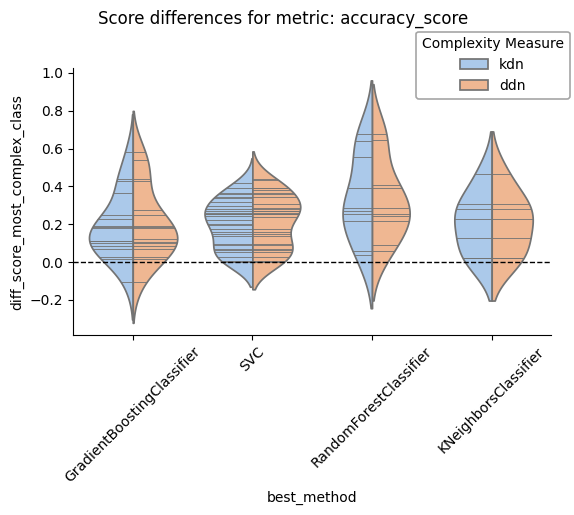

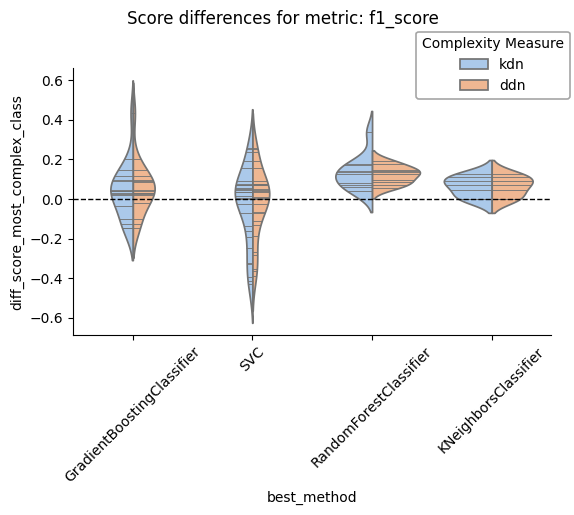

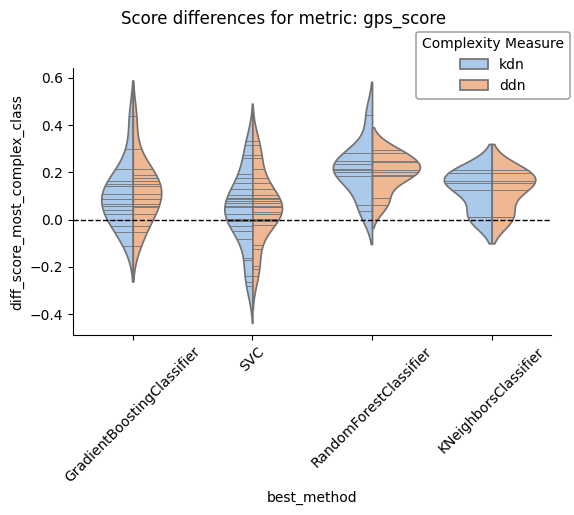

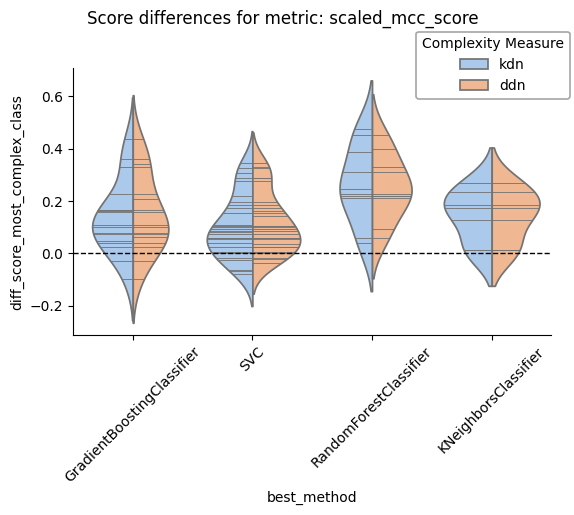

In [8]:
plot_score_differences(df_merged, diff='diff_score_most_complex_class', x_var='best_method')

In [16]:
calculate_grouped_statistics(df_merged, diff='diff_score_minority_class_complexity', x_var='best_method')

,best_method,metric_y,mean,std,min,max,count
0,GradientBoostingClassifier,ddn,0.112417,0.139684,-0.144416,0.581721,68
1,GradientBoostingClassifier,kdn,0.098519,0.132763,-0.145937,0.581721,68
2,KNeighborsClassifier,ddn,0.135271,0.113886,-0.000147,0.468197,28
3,KNeighborsClassifier,kdn,0.135271,0.113886,-0.000147,0.468197,28
4,RandomForestClassifier,ddn,0.225971,0.144962,0.058444,0.677778,40
5,RandomForestClassifier,kdn,0.237047,0.163997,0.038453,0.677778,40
6,SVC,ddn,0.091149,0.166101,-0.388638,0.441694,124
7,SVC,kdn,0.074822,0.172683,-0.430686,0.419102,124


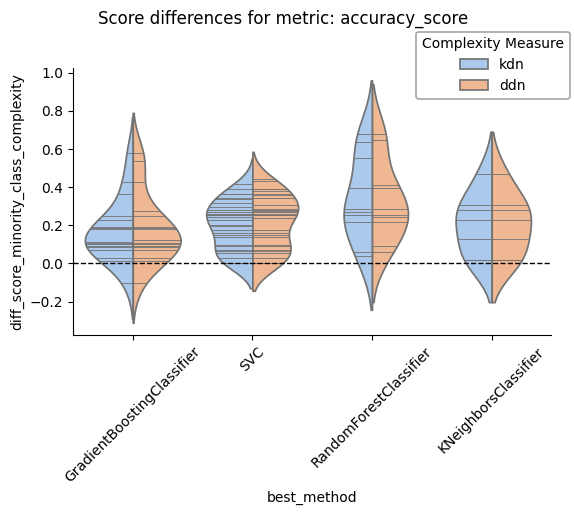

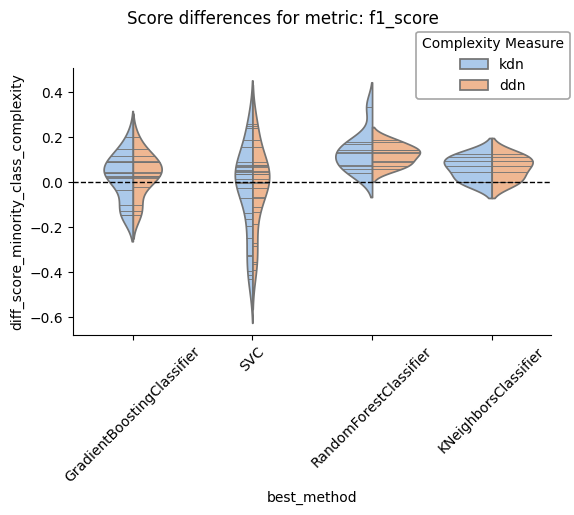

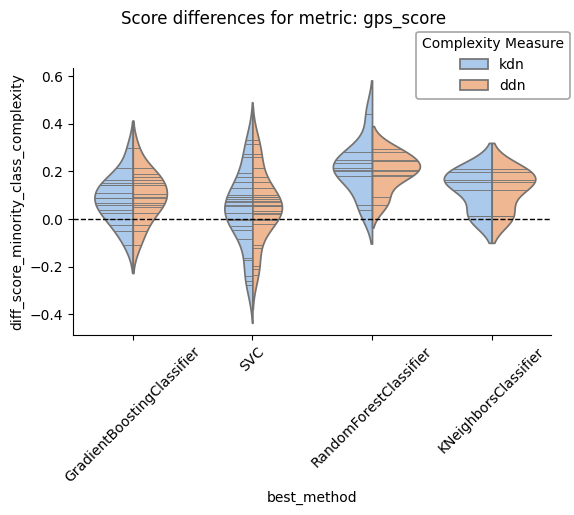

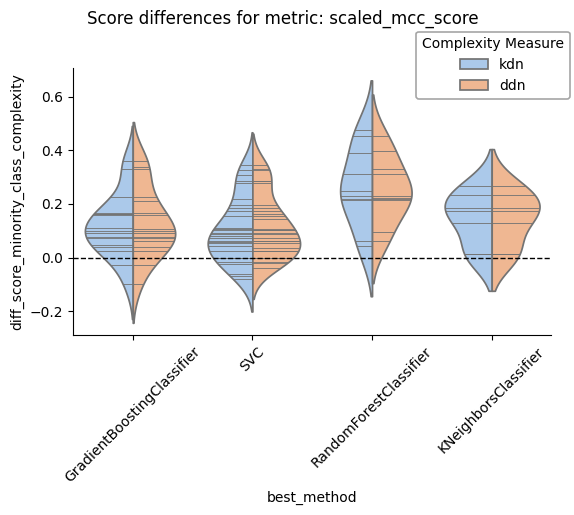

In [9]:
plot_score_differences(df_merged, diff='diff_score_minority_class_complexity', x_var='best_method')

In [17]:
calculate_grouped_statistics(df_merged, diff='diff_score_most_complex_class', x_var='class_prop_category')

,class_prop_category,metric_y,mean,std,min,max,count
0,0-0.1,ddn,0.086405,0.204819,-3.886377e-01,0.647494,80
1,0-0.1,kdn,0.066505,0.214480,-4.306864e-01,0.637690,80
2,0.1-0.2,ddn,0.164005,0.158577,-1.996014e-02,0.677778,40
3,0.1-0.2,kdn,0.145110,0.156226,-1.459367e-01,0.677778,40
4,0.2-0.3,ddn,0.205716,0.129204,-6.605267e-02,0.441694,52
5,0.2-0.3,kdn,0.206253,0.146878,-1.350976e-01,0.555562,52
6,0.3-0.4,ddn,0.116848,0.094732,-2.626488e-11,0.279763,40
7,0.3-0.4,kdn,0.116848,0.094716,-2.626488e-11,0.279763,40
8,0.4-0.5,ddn,0.090171,0.125367,-1.268198e-01,0.437155,48
9,0.4-0.5,kdn,0.086028,0.126371,-1.268198e-01,0.438123,48


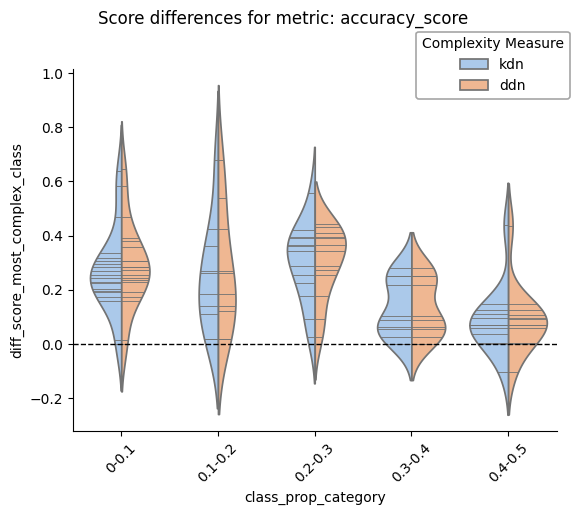

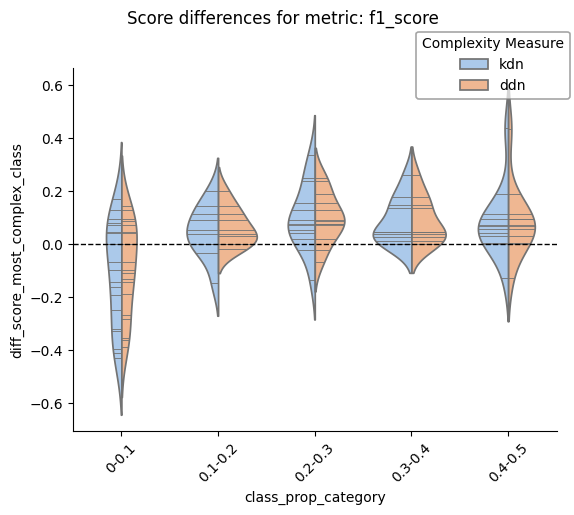

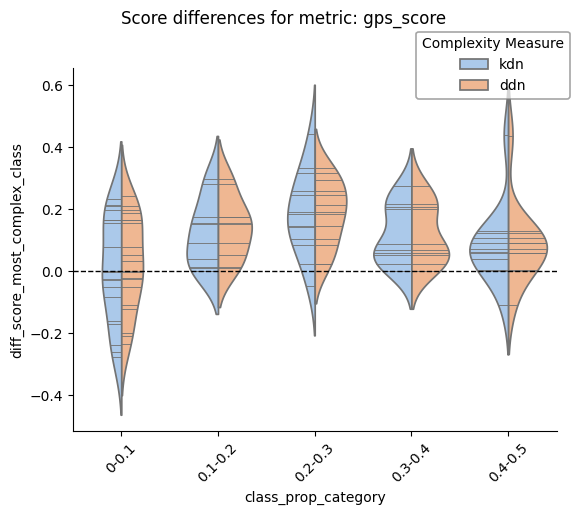

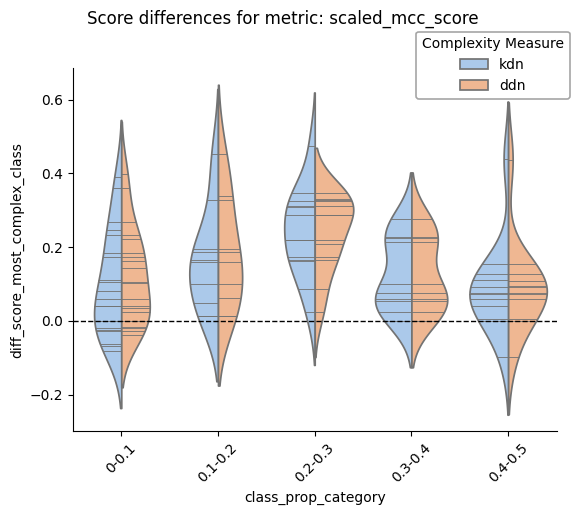

In [12]:
plot_score_differences(df_merged, diff='diff_score_most_complex_class', x_var='class_prop_category')

In [18]:
calculate_grouped_statistics(df_merged, diff='diff_score_minority_class_complexity', x_var='class_prop_category')

,class_prop_category,metric_y,mean,std,min,max,count
0,0-0.1,ddn,0.086405,0.204819,-3.886377e-01,0.647494,80
1,0-0.1,kdn,0.066505,0.214480,-4.306864e-01,0.637690,80
2,0.1-0.2,ddn,0.164005,0.158577,-1.996014e-02,0.677778,40
3,0.1-0.2,kdn,0.145110,0.156226,-1.459367e-01,0.677778,40
4,0.2-0.3,ddn,0.205716,0.129204,-6.605267e-02,0.441694,52
5,0.2-0.3,kdn,0.206253,0.146878,-1.350976e-01,0.555562,52
6,0.3-0.4,ddn,0.116848,0.094732,-2.626488e-11,0.279763,40
7,0.3-0.4,kdn,0.116848,0.094716,-2.626488e-11,0.279763,40
8,0.4-0.5,ddn,0.061032,0.068429,-1.268198e-01,0.190319,48
9,0.4-0.5,kdn,0.056723,0.067972,-1.268198e-01,0.190319,48


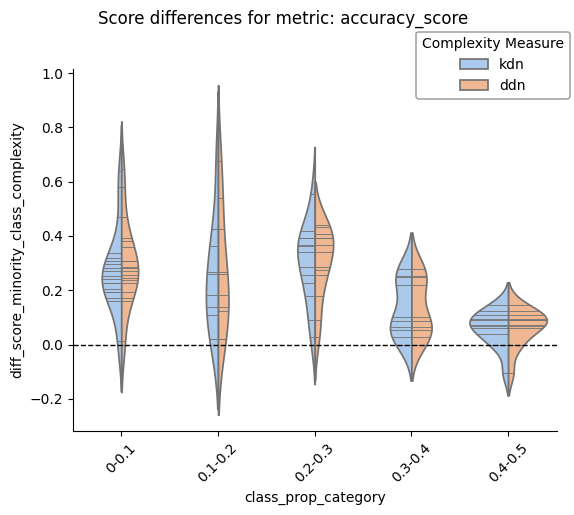

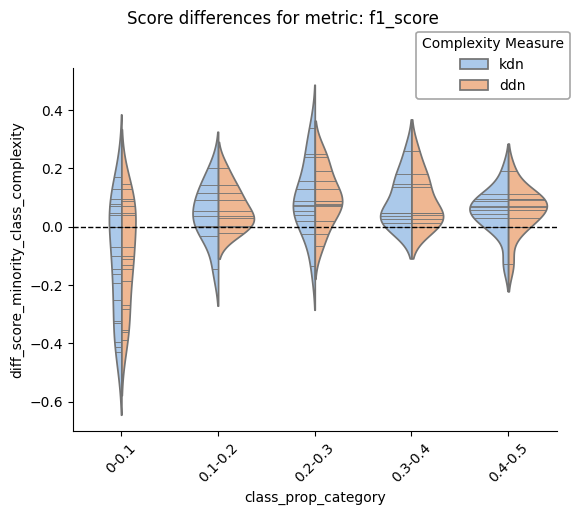

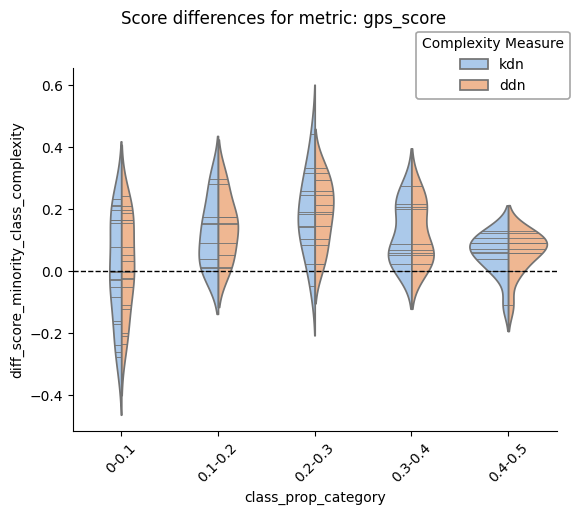

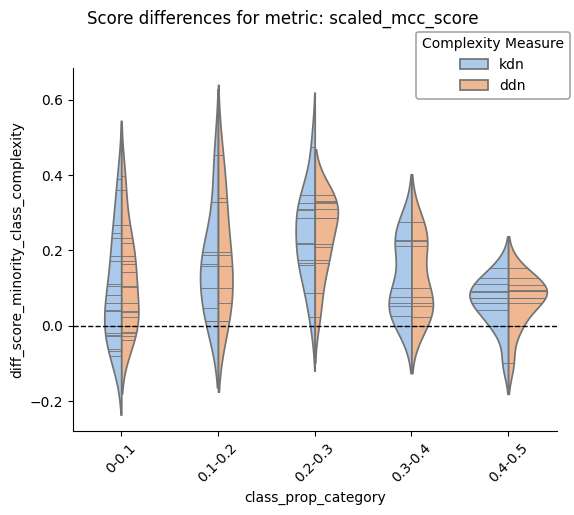

In [11]:
plot_score_differences(df_merged, diff='diff_score_minority_class_complexity', x_var='class_prop_category')

In [19]:
def create_pivot_table(df, diff='diff_score_most_complex_class', x_var='best_method', stat='mean'):
    """
    Creates a pivot table for a specified statistic of the 'diff' variable based on 'class_prop_category' and 'metric_y'.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the data.
    diff : str, optional (default='diff_score_most_complex_class')
        Column name for the variable for which to calculate statistics.
    x_var : str, optional (default='best_method')
        Column name for the variable to use as columns in the pivot table.
    stat : str, optional (default='mean')
        The statistic to display in the pivot table (e.g., 'mean', 'std', 'min', 'max').

    Returns:
    --------
    pd.DataFrame
        Pivot table with 'class_prop_category' and 'metric_y' as rows and the selected statistic for each 'best_method' as columns.
    """
    # Calculate grouped statistics
    grouped_stats = df.groupby(['class_prop_category', metric_y, x_var])[diff].agg(['median', 'mean', 'std', 'min', 'max', 'count']).reset_index()
    
    # Create the pivot table
    pivot_table = pd.pivot_table(grouped_stats, 
                                 values=stat, 
                                 index=['class_prop_category', metric_y], 
                                 columns=x_var, 
                                 aggfunc='first').reset_index()
    
    return pivot_table

In [21]:
create_pivot_table(df_merged, diff='diff_score_most_complex_class', x_var='best_method', metric_y='metric_y', stat='mean')

best_method,class_prop_category,metric_y,GradientBoostingClassifier,KNeighborsClassifier,RandomForestClassifier,SVC
0,0-0.1,ddn,0.086989,0.200473,0.271894,0.011041
1,0-0.1,kdn,0.086989,0.200473,0.280150,-0.026641
2,0.1-0.2,ddn,0.197682,0.011084,0.388833,0.146107
3,0.1-0.2,kdn,0.150445,0.011084,0.388833,0.146107
4,0.2-0.3,ddn,0.119463,NaN,0.255164,0.221489
5,0.2-0.3,kdn,0.103491,NaN,0.304013,0.208398
6,0.3-0.4,ddn,0.119247,NaN,0.204526,0.080338
7,0.3-0.4,kdn,0.119247,NaN,0.204526,0.080338
8,0.4-0.5,ddn,0.122248,0.122836,0.076274,0.063535
9,0.4-0.5,kdn,0.122897,0.122836,0.050122,0.063535


In [22]:
create_pivot_table(df_merged, diff='diff_score_minority_class_complexity', x_var='best_method', stat='mean')

best_method,class_prop_category,metric_y,GradientBoostingClassifier,KNeighborsClassifier,RandomForestClassifier,SVC
0,0-0.1,ddn,0.086989,0.200473,0.271894,0.011041
1,0-0.1,kdn,0.086989,0.200473,0.280150,-0.026641
2,0.1-0.2,ddn,0.197682,0.011084,0.388833,0.146107
3,0.1-0.2,kdn,0.150445,0.011084,0.388833,0.146107
4,0.2-0.3,ddn,0.119463,NaN,0.255164,0.221489
5,0.2-0.3,kdn,0.103491,NaN,0.304013,0.208398
6,0.3-0.4,ddn,0.119247,NaN,0.204526,0.080338
7,0.3-0.4,kdn,0.119247,NaN,0.204526,0.080338
8,0.4-0.5,ddn,0.035816,0.122836,0.076274,0.062747
9,0.4-0.5,kdn,0.035964,0.122836,0.050122,0.062747


In [19]:
import pandas as pd
from scipy.stats import f_oneway, kruskal

def evaluate_differences(df, variable='diff_score_minority_class_complexity', factor1='class_prop_category', factor2='best_method'):
    """
    Evaluates if there are significant differences in the specified variable according to two factors.

    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame containing the data.
    variable : str, optional (default='diff_score_minority_class_complexity')
        The name of the variable to analyze.
    factor1 : str, optional (default='class_prop_category')
        The first factor to consider in the analysis.
    factor2 : str, optional (default='best_method')
        The second factor to consider in the analysis.

    Returns:
    --------
    dict
        Dictionary with the results of the analysis for each combination of 'metric_x' and 'metric_y'.
    """
    results = {}

    # Group data by 'metric_x' and 'metric_y'
    grouped = df.groupby(['metric_x', 'metric_y'])
    
    for (metric_x, metric_y), group in grouped:
        # Create groups for the combination of the two factors
        group_data = group.groupby([factor1, factor2])[variable].apply(list)
        
        # Ensure that groups are lists and contain numeric values
        filtered_groups = [list(filter(pd.notna, g)) for g in group_data if isinstance(g, list) and len(g) > 1]

        # Check if there are enough groups for ANOVA/Kruskal-Wallis
        if len(filtered_groups) > 1:
            # Perform ANOVA or Kruskal-Wallis test
            try:
                anova_result = f_oneway(*filtered_groups)
                if pd.isna(anova_result.pvalue):
                    # If ANOVA result is NaN, use Kruskal-Wallis test
                    kruskal_result = kruskal(*filtered_groups)
                    results[(metric_x, metric_y)] = {'test': 'Kruskal-Wallis', 'p-value': kruskal_result.pvalue, 'statistic': kruskal_result.statistic}
                else:
                    results[(metric_x, metric_y)] = {'test': 'ANOVA', 'p-value': anova_result.pvalue, 'statistic': anova_result.statistic}
            except Exception as e:
                # Handle any errors and use Kruskal-Wallis as a fallback
                kruskal_result = kruskal(*filtered_groups)
                results[(metric_x, metric_y)] = {'test': 'Kruskal-Wallis', 'p-value': kruskal_result.pvalue, 'statistic': kruskal_result.statistic}
        else:
            results[(metric_x, metric_y)] = {'test': 'Insufficient groups', 'p-value': None, 'statistic': None}
    
    return results


In [21]:
anova_results = evaluate_differences(df_merged, variable='diff_score_minority_class_complexity', factor1='class_prop_category', factor2='best_method')

In [26]:
def generate_difference_report(results):
    """
    Generates a report explaining where significant differences were found based on ANOVA results.

    Parameters:
    -----------
    results : dict
        Dictionary with the results of the analysis for each combination of 'metric_x' and 'metric_y'.

    Returns:
    --------
    str
        A text report in English summarizing where significant differences were found.
    """
    report = "Based on the ANOVA tests, statistically significant differences in 'diff_score_minority_class_complexity' were observed according to 'class_prop_category' and 'best_method' across various combinations of 'metric_x' and 'metric_y'. The following combinations showed significant differences:\n\n"

    for (metric_x, metric_y), result in results.items():
        if result['p-value'] is not None and result['p-value'] < 0.05:
            report += f"- For {metric_x} and {metric_y}, the test used was {result['test']} with a p-value of {result['p-value']:.6f} and a test statistic of {result['statistic']:.4f}.\n"

    report += "\nThese results suggest that there are significant differences in 'diff_score_minority_class_complexity' across different levels of 'class_prop_category' and 'best_method' for the above combinations of 'metric_x' and 'metric_y'. Further post-hoc analysis is recommended to identify the specific groups that differ.\n"
    
    return report


In [27]:
report = generate_difference_report(anova_results)

print(report)

Based on the ANOVA tests, statistically significant differences in 'diff_score_minority_class_complexity' were observed according to 'class_prop_category' and 'best_method' across various combinations of 'metric_x' and 'metric_y'. The following combinations showed significant differences:

- For accuracy_score and ddn, the test used was ANOVA with a p-value of 0.000699 and a test statistic of 3.3818.
- For accuracy_score and kdn, the test used was ANOVA with a p-value of 0.000155 and a test statistic of 3.9373.
- For f1_score and ddn, the test used was ANOVA with a p-value of 0.000010 and a test statistic of 5.0086.
- For f1_score and kdn, the test used was ANOVA with a p-value of 0.000019 and a test statistic of 4.7615.
- For gps_score and ddn, the test used was ANOVA with a p-value of 0.000039 and a test statistic of 4.4710.
- For gps_score and kdn, the test used was ANOVA with a p-value of 0.000027 and a test statistic of 4.6083.
- For scaled_mcc_score and ddn, the test used was ANO

In [38]:
import pandas as pd
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def perform_post_hoc_analysis(df, variable='diff_score_minority_class_complexity', factor1='class_prop_category', factor2='best_method'):
    """
    Performs post-hoc analysis using Tukey's HSD to identify specific group differences.

    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame containing the data.
    variable : str, optional (default='diff_score_minority_class_complexity')
        The name of the variable to analyze.
    factor1 : str, optional (default='class_prop_category')
        The first factor to consider in the analysis.
    factor2 : str, optional (default='best_method')
        The second factor to consider in the analysis.

    Returns:
    --------
    dict
        Dictionary with the post-hoc analysis results for each combination of 'metric_x' and 'metric_y'.
    """
    post_hoc_results = {}

    # Group data by 'metric_x' and 'metric_y'
    grouped = df.groupby(['metric_x', 'metric_y'])
    
    for (metric_x, metric_y), group in grouped:
        # Create a combined factor for post-hoc analysis
        group['combined_factor'] = group[factor1].astype(str) + "_" + group[factor2].astype(str)
        
        # Ensure there are at least two groups with more than one observation each
        group_sizes = group['combined_factor'].value_counts()
        valid_groups = group_sizes[group_sizes > 1]

        if len(valid_groups) > 1:
            # Perform Tukey's HSD test
            tukey_result = pairwise_tukeyhsd(endog=group[variable], groups=group['combined_factor'], alpha=0.05)
            post_hoc_results[(metric_x, metric_y)] = tukey_result.summary()
        else:
            print(f"Not enough data for Tukey's HSD test for metric_x: {metric_x}, metric_y: {metric_y}.")
    
    return post_hoc_results


In [39]:
# Usar la función para realizar el análisis post-hoc
post_hoc_results = perform_post_hoc_analysis(df_merged)

# Mostrar los resultados del análisis post-hoc
if post_hoc_results:
    for key, result in post_hoc_results.items():
        print(f"Post-hoc analysis for {key}:\n", result)
else:
    print("No post-hoc results available.")

Post-hoc analysis for ('accuracy_score', 'ddn'):
                             Multiple Comparison of Means - Tukey HSD, FWER=0.05                             
              group1                             group2               meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------------------------
  0-0.1_GradientBoostingClassifier         0-0.1_KNeighborsClassifier   0.0581    1.0 -0.3047   0.421  False
  0-0.1_GradientBoostingClassifier       0-0.1_RandomForestClassifier   0.1826  0.981 -0.2511  0.6163  False
  0-0.1_GradientBoostingClassifier                          0-0.1_SVC  -0.0072    1.0 -0.3166  0.3023  False
  0-0.1_GradientBoostingClassifier 0.1-0.2_GradientBoostingClassifier   0.0546    1.0 -0.3082  0.4175  False
  0-0.1_GradientBoostingClassifier       0.1-0.2_KNeighborsClassifier   -0.244 0.8164 -0.6777  0.1897  False
  0-0.1_GradientBoostingClassifier     0.1-0.2_RandomForestClassifier   0.4145

In [40]:
def identify_significant_differences(post_hoc_results):
    """
    Identifies significant differences from the post-hoc analysis results.

    Parameters:
    -----------
    post_hoc_results : dict
        Dictionary containing the post-hoc Tukey HSD results for each combination of 'metric_x' and 'metric_y'.

    Returns:
    --------
    dict
        A dictionary with the combinations of 'metric_x' and 'metric_y' as keys and a list of significant differences as values.
    """
    significant_differences = {}

    for (metric_x, metric_y), result in post_hoc_results.items():
        # Convert the result to a DataFrame for easier filtering
        result_df = pd.DataFrame(result.data[1:], columns=result.data[0])
        
        # Filter rows where 'reject' is True
        significant_rows = result_df[result_df['reject'] == True]

        if not significant_rows.empty:
            significant_differences[(metric_x, metric_y)] = significant_rows[['group1', 'group2', 'meandiff', 'p-adj', 'lower', 'upper']].to_dict('records')

    return significant_differences

In [41]:
# Identify significant differences
significant_differences = identify_significant_differences(post_hoc_results)

# Show the significant differences
if significant_differences:
    for key, diffs in significant_differences.items():
        print(f"Significant differences for {key}:")
        for diff in diffs:
            print(diff)
else:
    print("No significant differences found.")

Significant differences for ('accuracy_score', 'ddn'):
{'group1': '0.1-0.2_KNeighborsClassifier', 'group2': '0.1-0.2_RandomForestClassifier', 'meandiff': 0.6585, 'p-adj': 0.0131, 'lower': 0.0767, 'upper': 1.2404}
{'group1': '0.1-0.2_RandomForestClassifier', 'group2': '0.3-0.4_SVC', 'meandiff': -0.5925, 'p-adj': 0.0122, 'lower': -1.1129, 'upper': -0.0721}
{'group1': '0.1-0.2_RandomForestClassifier', 'group2': '0.4-0.5_GradientBoostingClassifier', 'meandiff': -0.6365, 'p-adj': 0.0063, 'lower': -1.1676, 'upper': -0.1053}
{'group1': '0.1-0.2_RandomForestClassifier', 'group2': '0.4-0.5_RandomForestClassifier', 'meandiff': -0.602, 'p-adj': 0.0357, 'lower': -1.1839, 'upper': -0.0202}
{'group1': '0.1-0.2_RandomForestClassifier', 'group2': '0.4-0.5_SVC', 'meandiff': -0.6153, 'p-adj': 0.0076, 'lower': -1.1357, 'upper': -0.0948}
Significant differences for ('accuracy_score', 'kdn'):
{'group1': '0-0.1_RandomForestClassifier', 'group2': '0.4-0.5_GradientBoostingClassifier', 'meandiff': -0.4126, 'p-